In [17]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

In [2]:
import numpy as np

'''
The input vector as $x_t = [1, r_{t - M}, ... , r_t, F_{t - 1}] $, 
where $r_t$ is the change in value between the asset at time $t$ and $t - 1$, 
and $M$ is the number of time series inputs. 

This means that at every time step, the model will be fed its last position 
and a series of historical price changes that it can use to calculate its next position.

We can calculate all of the positions given price series x, and theta (time) with the following Python function:
'''

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

In [3]:
def returns(Ft, x, delta):
    '''
    calculate our returns R at each time step 
    delta$ is our transaction cost rate
    '''
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

In [4]:
def gradient(x, theta, delta):
    '''
    compute the derivative of the Sharpe ratio with respect to theta
    Using the chain rule and the above formulas we can write it as shown
    More info:
    http://cs229.stanford.edu/proj2006/Molina-StockTradingWithRecurrentReinforcementLearning.pdf
    '''
    Ft = positions(x, theta)
    R = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / T
    dBdR = 2. / T * R
    
    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, S

In [5]:
def train(x, epochs=2000, M=8, commission=0.0025, learning_rate = 0.3):
    '''
    optimize our parameters using gradient ascent. 
    We update our theta each epoch using theta = theta + alpha(dS _T /  d(theta)}$, where alpha is our learning rate.
    $\theta = \theta + \alpha{dS _T \over d\theta}$
    '''
    theta = np.random.rand(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate

        sharpes[i] = sharpe
    
    
    print("finished training")
    return theta, sharpes

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 150
import pandas as pd

btc = pd.read_csv("bitstampUSD.csv", names=["utc", "price", "volume"]).set_index('utc')
btc.index = pd.to_datetime(btc.index, unit='s')
rets = btc['price'].diff()[1:]

In [12]:
x = np.array(rets)

'''
Model on 1000 samples, and then trade on the next 200 samples
Use a lookback of 8 ticks
'''

N = 1000
P = 200
x_train = x[-(N+P):-P]
x_test = x[-P:]

std = np.std(x_train)
mean = np.mean(x_train)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [22]:
#np.random.seed(0) #8 tick lookback
'''Works best w M = 20 + (M = 50 GREAT) (in test)'''
theta, sharpes = train(x_train, epochs=2000, M=50, commission=0.0025, learning_rate=0.3)

finished training


Text(0, 0.5, 'Sharpe Ratio')

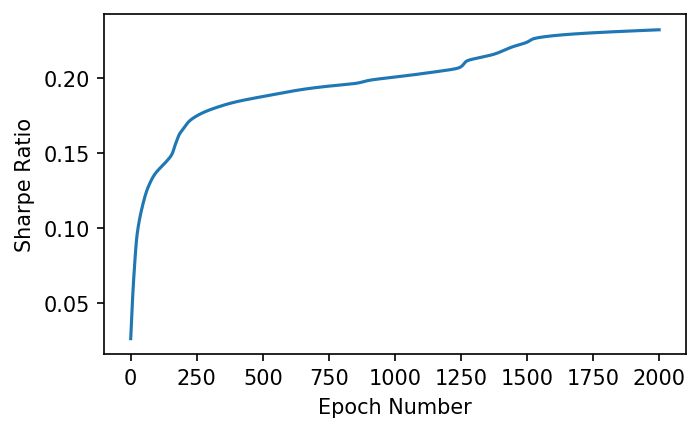

In [23]:
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio') #;

Text(0.5, 1.0, 'RL Model vs. Buy and Hold - Training Data')

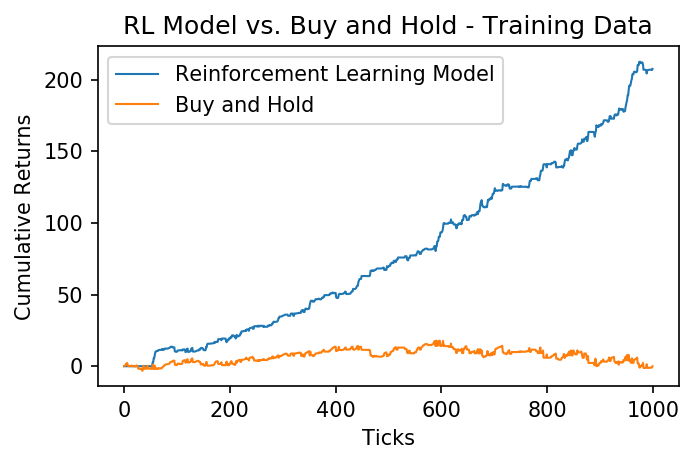

In [24]:
train_returns = returns(positions(x_train, theta), x_train, 0.0025)
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_train.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data")

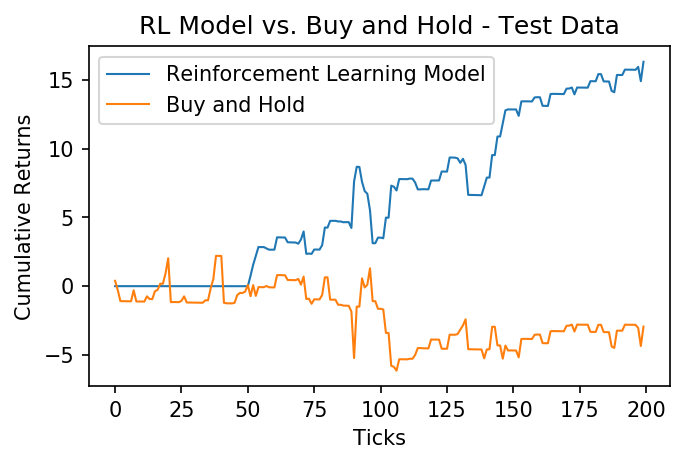

In [25]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_test.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data");

In [45]:
mu = test_returns.mean()
sig = test_returns.std()
sr = np.sqrt(mu / sig) * 252 * 24 * 4
sr

9305.807496419762

In [46]:
#btc.tail(200) #200 ticks is ~ 15M